In [2]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

#Import libraries for multicollineaarity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Import libraries for transformations
import joblib



In [3]:
import sys
sys.path.append(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try')
import SARIMAX

SARIMAX for Luzon
DATA PREPROCESSING

In [4]:
#Import the necessary files
labels_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon\train_labels_transformed.csv'
data_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon\train_data_transformed.csv'
test_data_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_data.csv'
test_labels_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_labels.csv'
transformed_data=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/data_transformed.csv'
transformed_test=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_data_transformed.csv'
complete_data = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/LUZ_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)
transformed_test_data = pd.read_csv(transformed_test)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]

#80% train set, 20% test
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)



In [5]:
#Prepare the dataframes
#Rename columns of complete transformed test dataframe
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)

#Rename columns of complete transformed dataframe
transformed_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)

#Define transformed dataset for test set GWAP and LWAP
transformed_test_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)
transformed_labels_test = pd.DataFrame(transformed_test_data, columns = labels_columns)

#Lag the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Remove GWAP and LWAP from exogenous set
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])


Multicollinearity Test


In [6]:
%run SARIMAX.py
transformed_exog = remove_multicollinear(transformed_exog, 10)
calculate_vif(transformed_exog)

Dropping RAINFALL_Tanay with VIF of 174.08283255131474
Dropping TMAX_Tanay with VIF of 132.1223694762746
Dropping TMIN_Tanay with VIF of 99.23732063588601
Dropping TMAX_Clark with VIF of 84.93049926613556
Dropping TMAX_NAIA with VIF of 77.67905021924017
Dropping TMIN_Clark with VIF of 61.97891534839404
Dropping TMAX_Tayabas with VIF of 59.167132687050795
Dropping TMIN_Casiguran with VIF of 53.81803211856434
Dropping TMAX_Calapan with VIF of 51.99886277051117
Dropping TMIN_NAIA with VIF of 51.021090827018966
Dropping TMAX_CLSU with VIF of 48.76748098992788
Dropping TMAX_Science Garden with VIF of 43.29783810374063
Dropping Hourly Demand with VIF of 40.62539496213083
Dropping TMIN_CLSU with VIF of 40.05023504345063
Dropping TMIN_Cubi Point with VIF of 32.88546370195628
Dropping TMIN_Calapan with VIF of 31.1056384380771
Dropping TMAX_Ambulong with VIF of 29.991306627331998
Dropping TMAX_SanJose with VIF of 28.146558863701543
Dropping TMIN_Ambulong with VIF of 27.377264445588384
Dropping R

,feature,VIF
0,FLOW_LUZ,6.620961
1,TMAX_Cubi Point,8.766317
2,TMIN_Science Garden,9.758032
3,RESERVE_GWAP_Fr,6.740527
4,RESERVE_GWAP_Rd,4.675492
5,RESERVE_GWAP_Dr,4.554849
6,RAINFALL_Science Garden,4.785823
7,RAINFALL_San Jose,6.685964
8,RAINFALL_Tayabas,4.191285
9,RAINFALL_Casiguran,9.145601


Prepare GWAP, LWAP, and exog variables

In [7]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = transformed_labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]

#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = transformed_labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]

#Preparing the exog datasets
train_exog = transformed_exog[:train_size]
test_exog = transformed_exog[train_size:]

#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [8]:
#Applying the inverse transformations
#Loading inverse transformations for Luzon

minmax_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/boxcox_pipeliney.pkl')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\A

In [9]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Luzon GWAP")
lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

Differencing

In [10]:
%run SARIMAX.py

#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)

#Perform differencing on train exogenous data
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

#Perform differencing on test exogenous data
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:53: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:53: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:81: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:81: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual 

Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.
Column 'FLOW_LUZ' is stationary after differencing 0 times.
Column 'TMAX_Cubi Point' is stationary after differencing 0 times.
Column 'TMIN_Science Garden' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 0 times.
Column 'RAINFALL_San Jose' is stationary after differencing 0 times.
Column 'RAINFALL_Tayabas' is stationary after differencing 0 times.
Column 'RAINFALL_Casiguran' is stationary after differencing 1 times.
Column 'RAINFALL_Clark' is stationary after differencing 0 times.
Column 'FLOW_LUZ' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 1 times.
Column 'TMIN_Science Garden' is 

C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:81: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:81: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:81: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try\SARIMAX.py:81: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual 

Order Specification

The ACF for GWAP is seen below
The PACF for GWAP is seen below


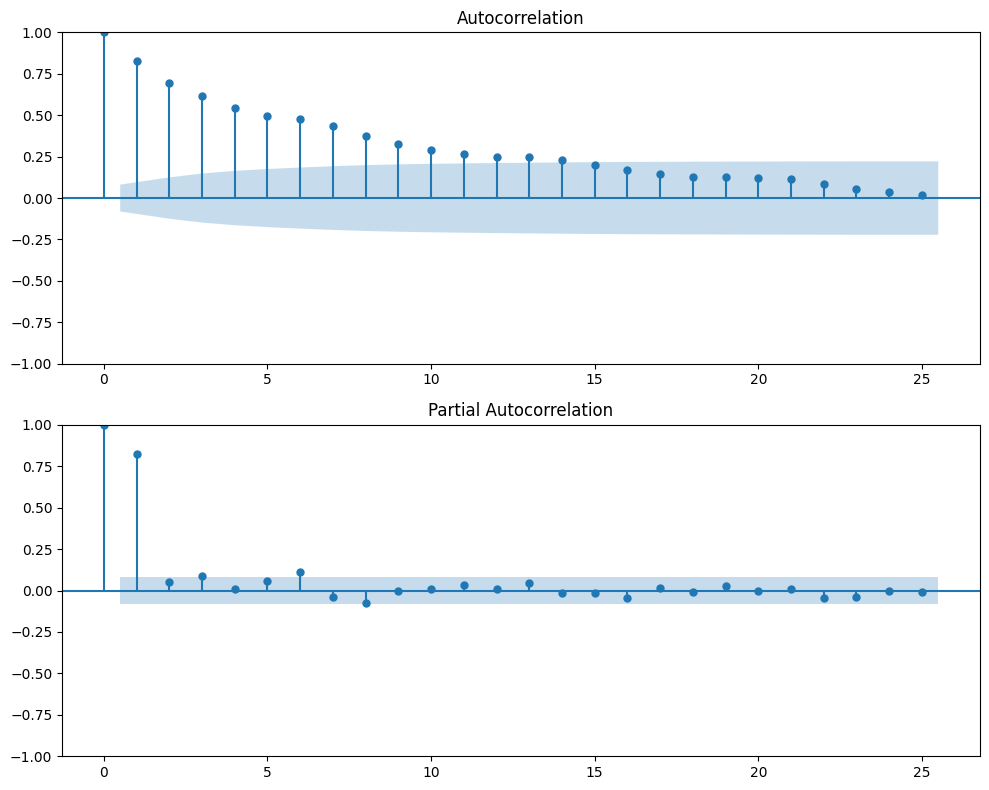

The ACF for LWAP is seen below
The PACF for LWAP is seen below


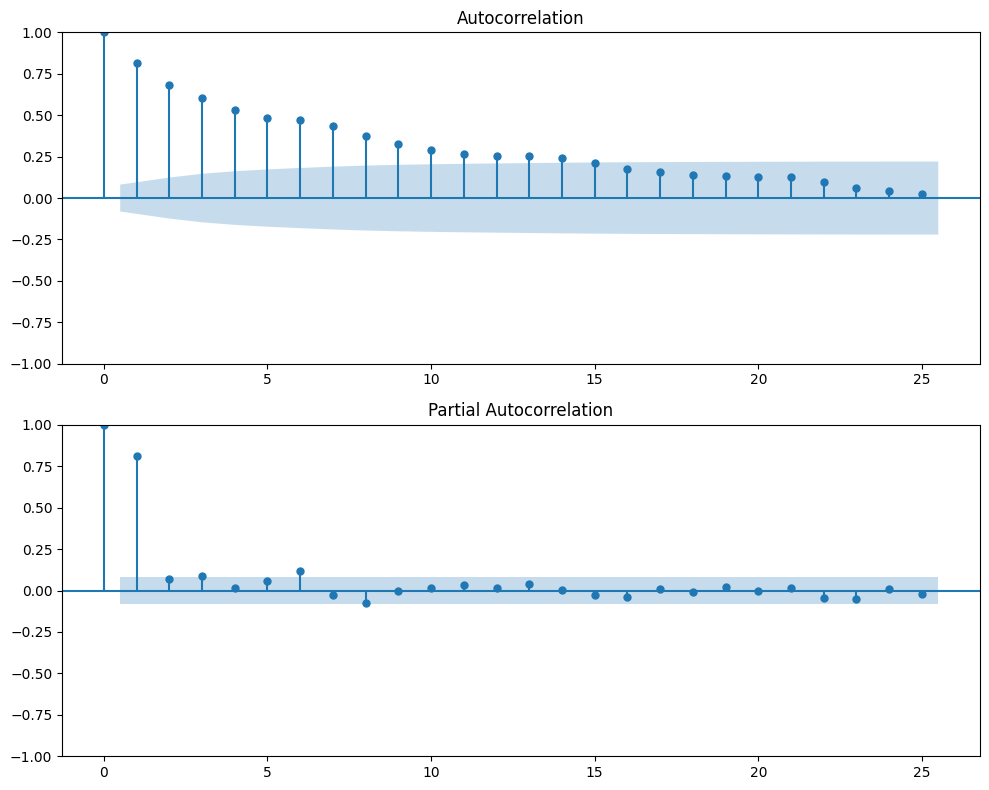

In [11]:
%run SARIMAX.py

plot_orders(GWAP_train, lags=25, alpha=0.05, var='GWAP')
plot_orders(LWAP_train, lags=25, alpha=0.05, var='LWAP')

GWAP and LWAP Forecasting

In [66]:
%run SARIMAX.py
#Run seasonal_auto_arima function on GWAP 
#Use max_p and max_q based on acf and pacf plots
GWAP_sarimax = seasonal_auto_arima(GWAP_train, max_p=1, max_d=2, max_q=13, exog_data=diff_exog_train )

#Display results of previous function
GWAP_sarimax

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 6 and an AIC of -1070.7818288347298


ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 6), suppress_warnings=True)

In [67]:
%run SARIMAX.py
#Run seasonal_auto_arima function on GWAP 
#Use max_p and max_q based on acf and pacf plots
LWAP_sarimax = seasonal_auto_arima(LWAP_train, max_p=1, max_d=2, max_q=14, exog_data=diff_exog_train )

#Display results of previous function
LWAP_sarimax

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 7 and an AIC of -1030.783266941296


ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(1, 0, 0, 7), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.954305
         Iterations: 8
         Function evaluations: 1136
                                     SARIMAX Results                                     
Dep. Variable:                              GWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 6)   Log Likelihood                 557.314
Date:                           Thu, 27 Feb 2025   AIC                          -1084.629
Time:                                   11:39:51   BIC                          -1019.106
Sample:                               01-01-2022   HQIC                         -1059.089
                                    - 08-07-2023                                         
Covariance Type:                             opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.921779
         Iterations: 8
         Function evaluations: 1129
                                     SARIMAX Results                                      
Dep. Variable:                               LWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 538.319
Date:                            Thu, 27 Feb 2025   AIC                          -1046.638
Time:                                    11:39:59   BIC                           -981.116
Sample:                                01-01-2022   HQIC                         -1021.099
                                     - 08-07-2023                                         
Covariance Type:                              opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

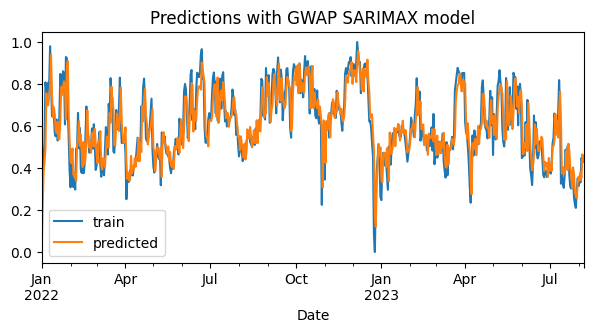

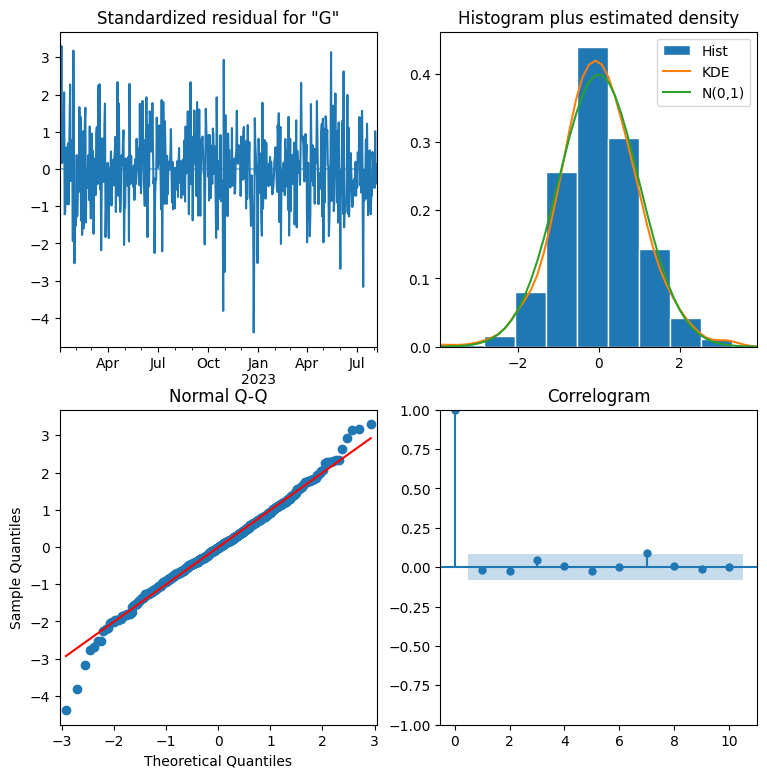

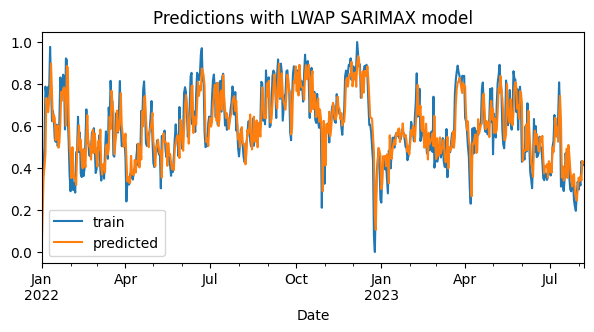

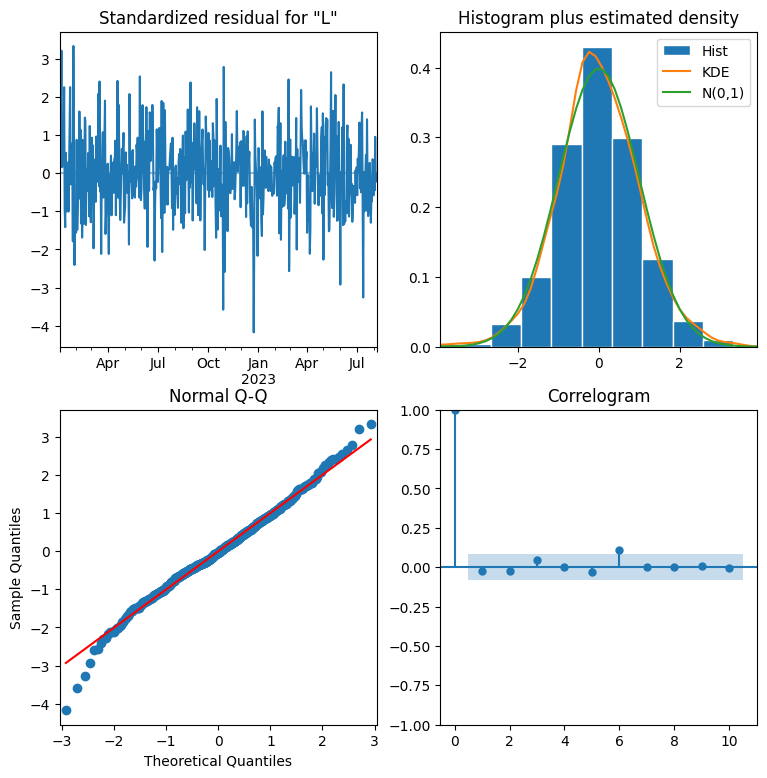

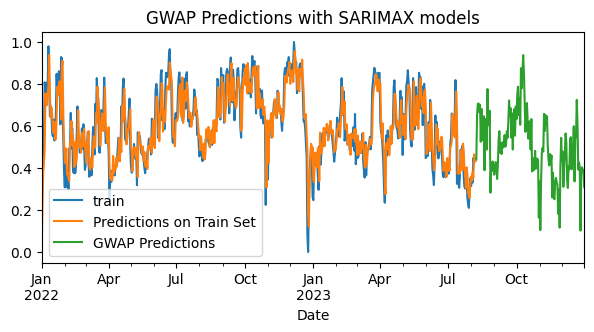

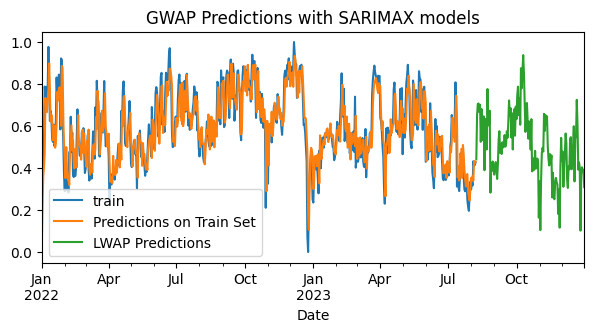

In [12]:
#Optimized orders for GWAP are (1,1,1)(0,0,1,6) and for LWAP are (1,1,1)(1,0,0)(7)
#This function fits the model and plots predictions on the train set; shows the summary of results and residuals diagnostics; and predicts on train set
%run SARIMAX.py

gwap_predictions, lwap_predictions = fit_SARIMAX(GWAP_train, LWAP_train, train_exog=diff_exog_train, gwap_order=(1,1,1), gwap_seasonal_order=(0,0,1,6), lwap_order = (1,1,1), lwap_seasonal_order=(1,0,0,7), GWAP_train = GWAP_train, LWAP_train =LWAP_train, GWAP_test=GWAP_test, LWAP_test=LWAP_test, exog_test = diff_exog_test)


Applying inverse transformations

In [13]:
#Combine gwap and lwap predicions in one data set
all_predictions = pd.concat([gwap_predictions, lwap_predictions], axis=1)

#Apply inverse transformations and convert to dataframe
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

#Separate GWAP and LWAP datasets
GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



Mean Absolute Error (MAE) on Test Set for GWAP: 2173.774951596343
Root Mean Squared Error (RMSE) on Test Set for GWAP: 3524.048397805398
Mean Absolute Percentage Error (MAPE) on Test Set for LWAP: 39.651936030051914


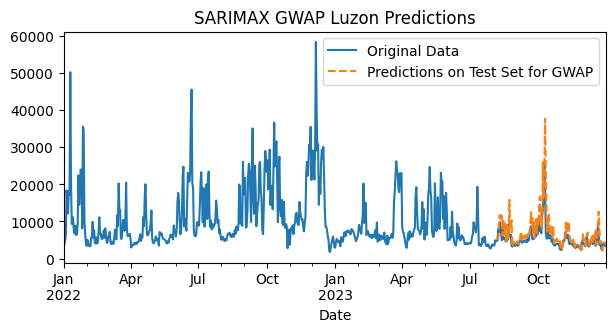

Mean Absolute Error (MAE) on Test Set for LWAP: 2645.8206274167683
Root Mean Squared Error (RMSE) on Test Set for LWAP: 3524.048397805398
Mean Absolute Percentage Error (MAPE) on Test Set for LWAP: 46.540028687848654


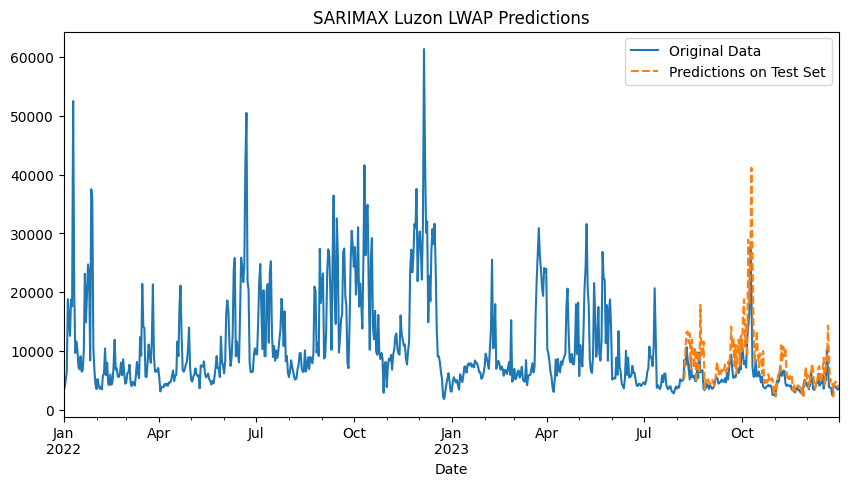

In [14]:
%run SARIMAX.py
evaluate_models(GWAP, LWAP, GWAP_test_inversed, GWAP_predictions_inverse, LWAP_test_inversed, LWAP_predictions_inverse, Region='Luzon')


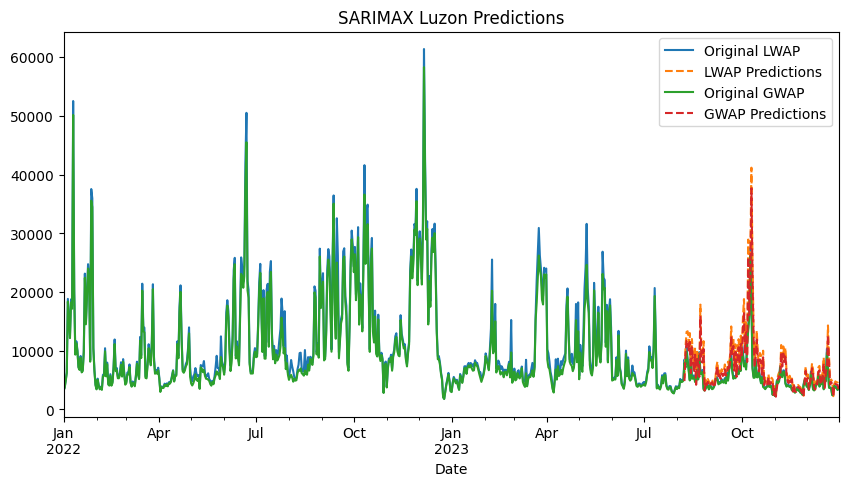

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Luzon Predictions')
ax.legend()
plt.show()

In [16]:
GWAP_predictions_inverse.to_csv('luz-gwap-predictions.csv', index=False)
LWAP_predictions_inverse.to_csv('luz-lwap-predictions.csv', index=False)